<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#took-out-'20200121_006'-because-not-necessarily-an-sGRC....-some-other-cell-type?-CMD-inhibition-not-there-at-rest" data-toc-modified-id="took-out-'20200121_006'-because-not-necessarily-an-sGRC....-some-other-cell-type?-CMD-inhibition-not-there-at-rest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>took out '20200121_006' because not necessarily an sGRC.... some other cell type? CMD inhibition not there at rest</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from scipy import signal

import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
sys.path.append('/Users/kperks/mnt/engram/scripts/Python/Analysis/')
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable

In [3]:
def compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur):
    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

    CmdTrig = expt.get_events('CmdTrig')

    #uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-10,15)

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    #coupled
#     bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['C'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

#     trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-10,15)
    plt.plot(xtime,cmd_R,color = 'black')

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    plt.figure(figsize = (4,5))
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-2,15)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift']),Ramp_uc,Ramp_c

def uncoupled_ampshift(expt,bout_uc,sweepdur):
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    CmdTrig = expt.get_events('CmdTrig')

    #uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(8,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep,color = colinds[i],lw = 3);
    plt.ylim(-10,50)

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])
    
    plt.figure(figsize = (5,5))
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
    plt.ylim(-5,50)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift']),Ramp_uc

def coupled_ampshift(expt,bout_c,sweepdur):    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    CmdTrig = expt.get_events('CmdTrig')
    
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['C'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

    trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(8,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-10,50)

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    plt.figure(figsize = (5,5))
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-5,50)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift']),Ramp_c

def calc_peaks(xtime,sweeps, order, min_peakt,threshold_h,dt):
    R = sweeps #np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    if len(epsp)>0:
        epsp = np.min(epsp)
    elif len(epsp)==0:
        epsp = np.NaN

    R_filt = R #signal.medfilt(R,[11])
    y = signal.medfilt(np.concatenate([[0],np.diff(R_filt)]),[25]) #-threshold_dvdt
    accel = signal.medfilt(np.concatenate([[0],np.diff(y)]),[11])   

    dvdt_start = int(0.002/dt)
    if ~np.isnan([epsp]).any():
        epsp_t = xtime[epsp]
        max_dvdt = np.max(y[dvdt_start:epsp])
        dvdt_threshold = np.max([0.01,0.15*max_dvdt])

        onset_options = np.where((np.sign(y-dvdt_threshold)>0) & (np.sign(accel)>=0))[0]
        valid_onsets = onset_options[(onset_options>dvdt_start)&(onset_options<epsp)]
        if len(valid_onsets) > 0:
            if (epsp_t-(np.min(valid_onsets)*dt)) > 0: #ensure that onset is before peak
                epsp_onset_ind = np.min(valid_onsets) #min after stim artifact
                epsp_amp = R[epsp]-R[epsp_onset_ind]
                epsp_onset = xtime[epsp_onset_ind]
            elif (epsp_t-(np.min(valid_onsets)*dt)) <= 0:
                epsp_t = np.NaN
                epsp_onset = np.NaN
                epsp_amp = 0
        elif len(valid_onsets)==0:
            epsp_t = np.NaN
            epsp_onset = np.NaN
            epsp_amp = 0
    elif np.isnan([epsp]).any():
        epsp_t = np.NaN
        epsp_onset = np.NaN
        epsp_amp = 0    

    return epsp_t, epsp_amp, epsp_onset



In [4]:
exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
data_folder = exptpath / 'data_raw'

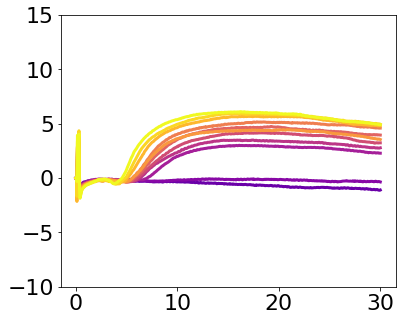

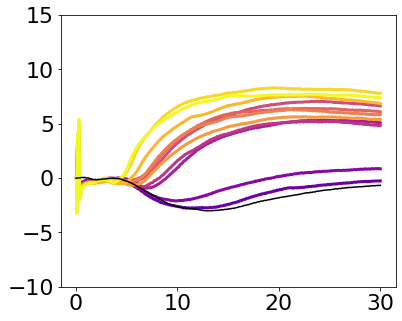

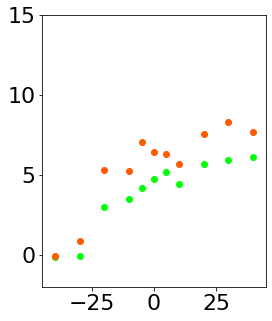

In [19]:
exptname = '20200719_000'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# bias -65
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0],
         expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)



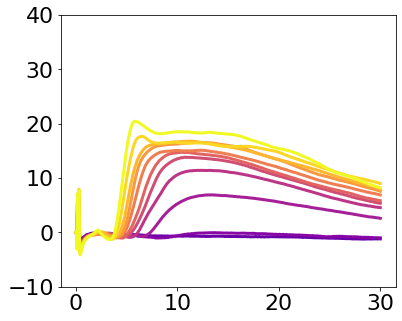

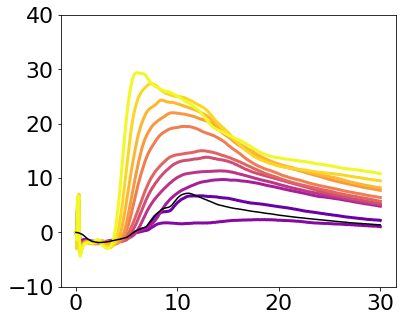

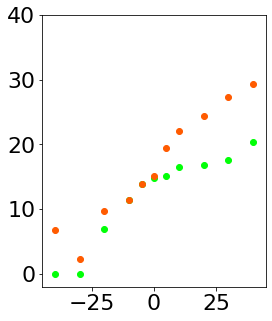

In [8]:
exptname = '20200718_000'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# bias -65
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0],
          expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)



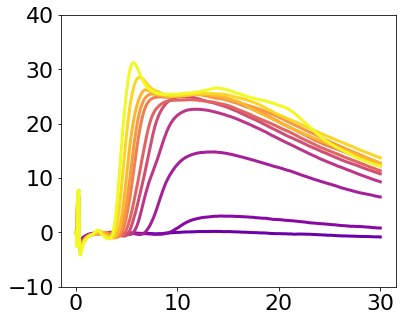

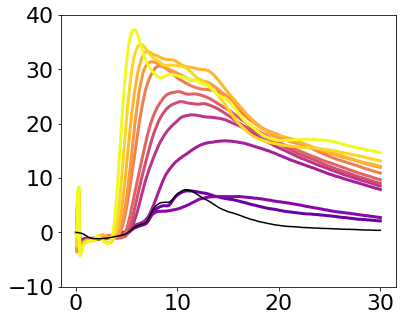

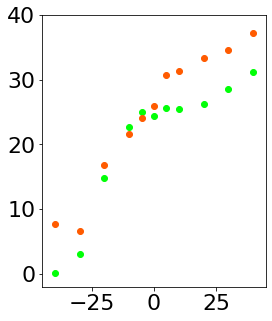

In [9]:
# bias -80
########
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


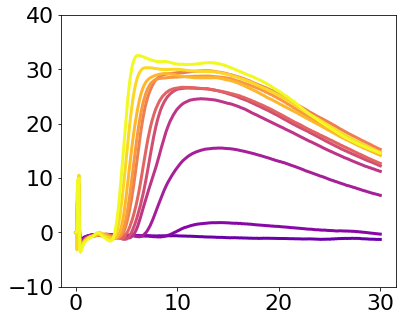

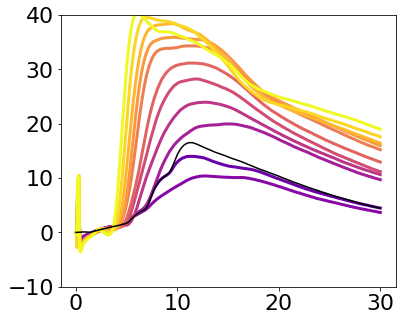

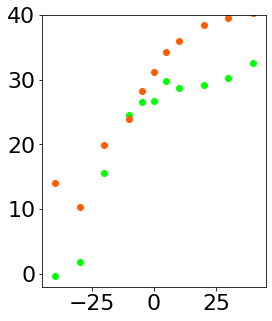

In [11]:
# bias to -95
########
bout_uc = [expt.get_bout_win('R','Keyboard')[4]]
bout_c = [expt.get_bout_win('N','Keyboard')[3]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


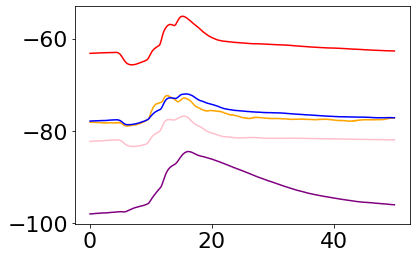

In [16]:
# cmd at different holding potentials
plt.figure()


bout = [expt.get_bout_win('B','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values
xtime, sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
plt.plot(xtime,np.mean(sweeps,1),color='red');

bout = [expt.get_bout_win('B','Keyboard')[5],
        expt.get_bout_win('B','Keyboard')[6]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values
xtime, sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
plt.plot(xtime,np.mean(sweeps,1),color='pink');

bout = [expt.get_bout_win('B','Keyboard')[2]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values
xtime, sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
plt.plot(xtime,np.mean(sweeps,1),color='orange');


bout = [expt.get_bout_win('B','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values
xtime, sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
plt.plot(xtime,np.mean(sweeps,1),color='blue');


bout = [expt.get_bout_win('B','Keyboard')[3],
       expt.get_bout_win('B','Keyboard')[4]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values
xtime, sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
plt.plot(xtime,np.mean(sweeps,1),color='purple');

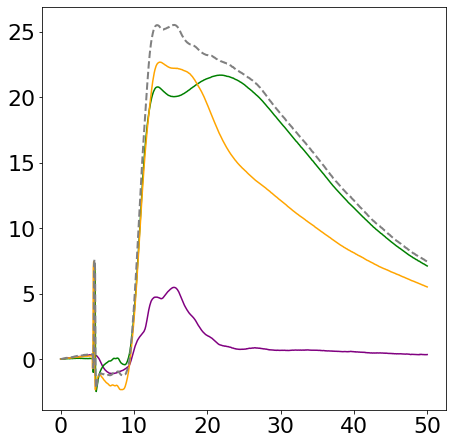

In [13]:
bout = [expt.get_bout_win('U','Keyboard')[0],
       expt.get_bout_win('U','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
u_df = expt.filter_marker_df_code(bout_df,['U'])
u_t = u_df.time.values-0.0001

bout = [expt.get_bout_win('B','Keyboard')[5],
        expt.get_bout_win('B','Keyboard')[6]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values

bout = [expt.get_bout_win('C','Keyboard')[0],
        expt.get_bout_win('C','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
c_df = expt.filter_marker_df_code(bout_df,['C'])
b_df = expt.filter_marker_df_code(bout_df,['B'])
c_t = c_df.time.values
#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

sweepdur = 0.050
basedur = 0.004
nsweeps = 3

fig = plt.figure(figsize = (7,8));ax = fig.add_axes([0.1,0.2,0.8,0.7])

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
cmdR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cmdR,color='purple');

xtime,sweeps = expt.get_sweepsmat('lowgain',u_t-c_latency,sweepdur)
uR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,uR,color='green');

xtime,sweeps = expt.get_sweepsmat('lowgain',c_t-c_latency,sweepdur)
cR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cR,color='orange');

predictedR = cmdR+uR
ax.plot(xtime,predictedR,color='gray',linewidth = 2,linestyle='--');


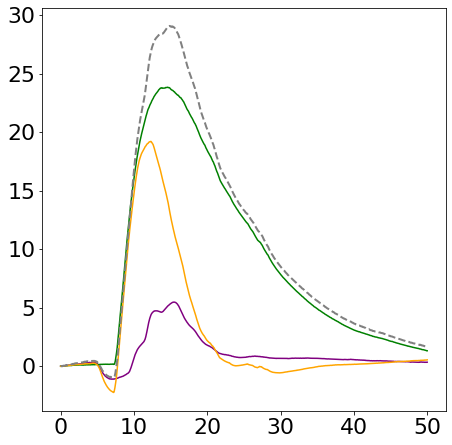

In [12]:
bout = [expt.get_bout_win('e','Keyboard')[0],
        expt.get_bout_win('e','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
u_df = expt.filter_marker_df_code(bout_df,['e'])
u_t = u_df.time.values-0.0001

bout = [expt.get_bout_win('B','Keyboard')[5],
       expt.get_bout_win('B','Keyboard')[6]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values

bout = [expt.get_bout_win('E','Keyboard')[0],
        expt.get_bout_win('E','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
c_df = expt.filter_marker_df_code(bout_df,['E'])
b_df = expt.filter_marker_df_code(bout_df,['B'])
c_t = c_df.time.values
#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

sweepdur = 0.050
basedur = 0.004
nsweeps = 3

fig = plt.figure(figsize = (7,8));ax = fig.add_axes([0.1,0.2,0.8,0.7])

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
cmdR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cmdR,color='purple');

xtime,sweeps = expt.get_sweepsmat('lowgain',u_t-c_latency,sweepdur)
uR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,uR,color='green');

xtime,sweeps = expt.get_sweepsmat('lowgain',c_t-c_latency,sweepdur)
cR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cR,color='orange');

predictedR = cmdR+uR
ax.plot(xtime,predictedR,color='gray',linewidth = 2,linestyle='--');


/Users/kperks/mnt/engram/spikedata/data_raw/20200614/20200614_000.smr


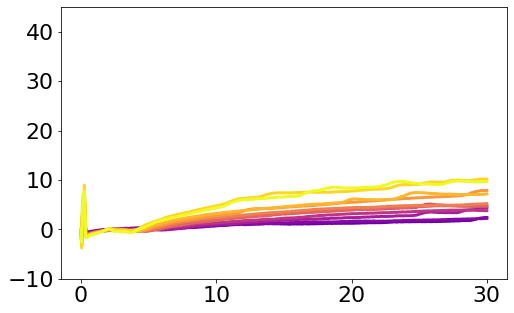

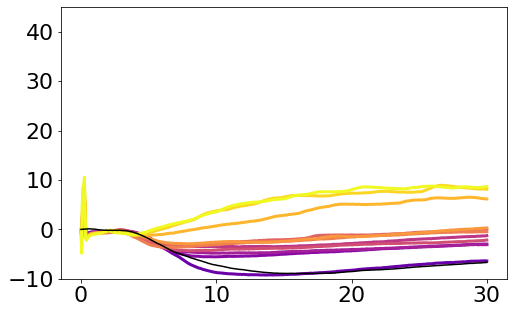

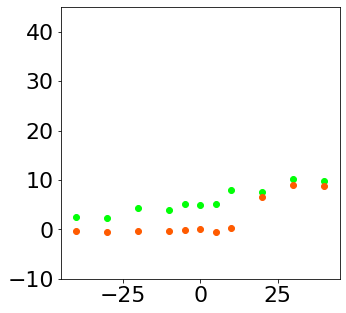

In [5]:
exptname = '20200614_000'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# rest
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)



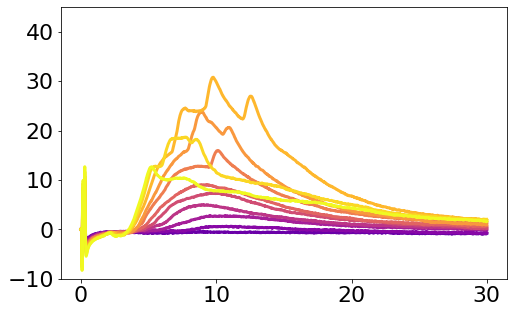

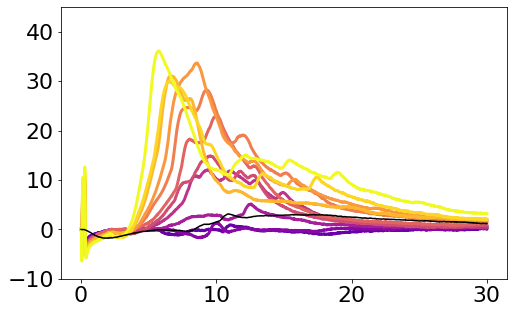

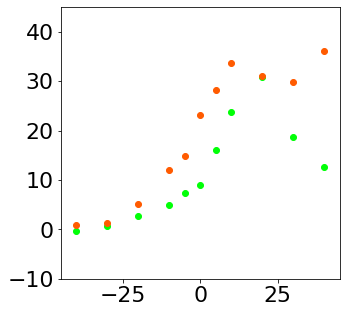

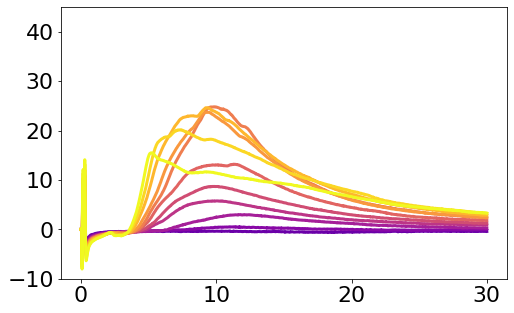

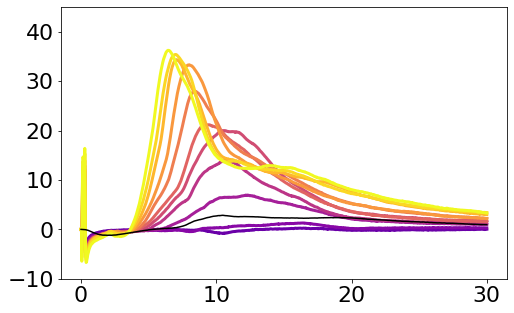

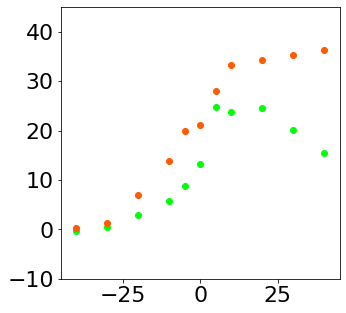

In [74]:
exptname = '20200606_001'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# rest
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# still biased to -70mV
########
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


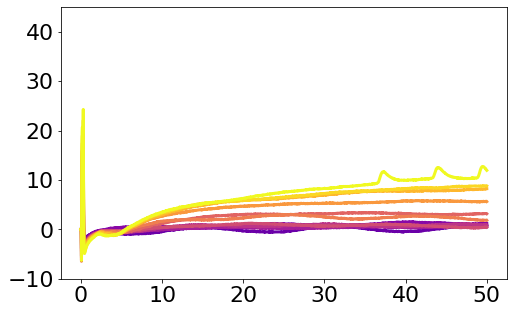

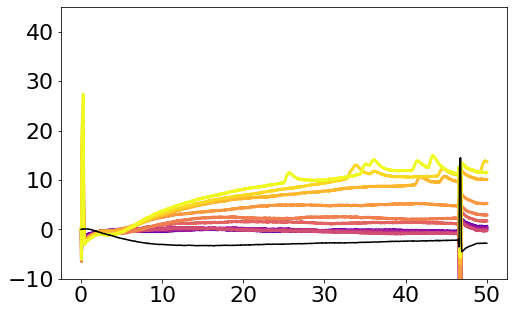

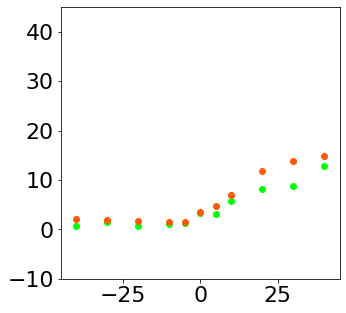

In [76]:
exptname = '20200606_006'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# rest
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.05)



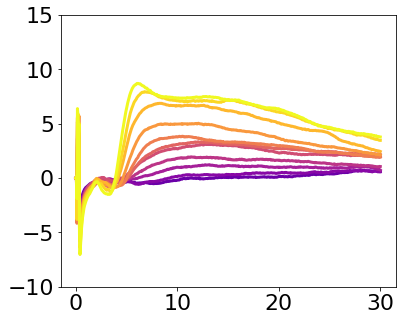

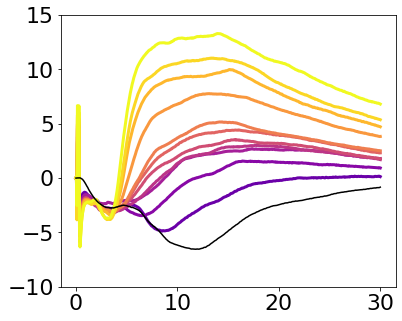

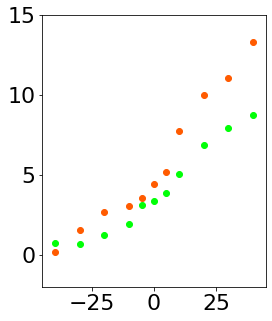

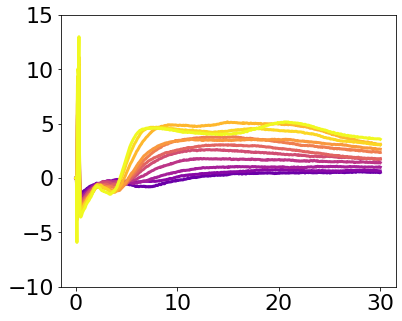

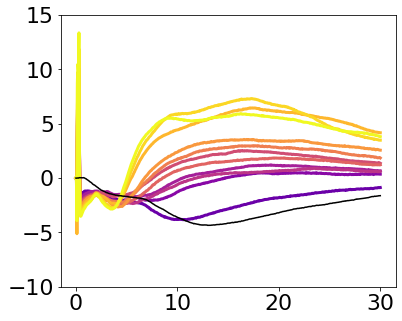

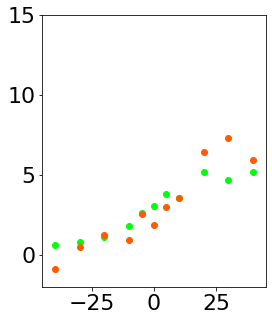

In [11]:
exptname = '20200607_000'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# biased to -60mV
########
bout_uc = [expt.get_bout_win('R','Keyboard')[1],
          expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[1],
         expt.get_bout_win('N','Keyboard')[2]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# still biased to -60mV; later in recording after waveform inject
########
bout_uc = [expt.get_bout_win('R','Keyboard')[3]]
bout_c = [expt.get_bout_win('N','Keyboard')[3]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

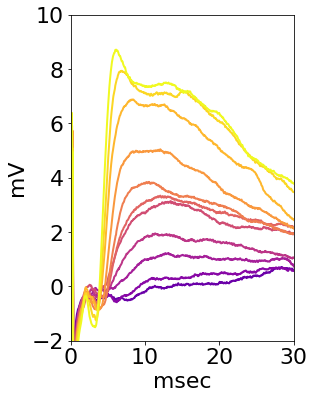

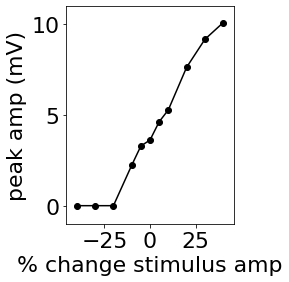

In [27]:
sweepdur = 0.03
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

trialmat = []
for a in np.unique(trial_df['ampshift_round']):
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

dt = expt.get_dt('lowgain')

min_peakt = 0.002 #(s)
threshold_h = 0.5 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

sweepdur = 0.03
basedur = 0.004

fsl = []
onset = []
amp = []
for sweep in trialmat.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])
onset = np.asarray(onset)
amp = np.asarray(amp)
fsl = np.asarray(fsl)

plt.figure(figsize=(4,6))
colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
for i,sweep in enumerate(trialmat.T):
    plt.plot(xtime,sweep,color = colinds[i],lw = 2);
plt.xlim(0,30)
plt.ylim(-2,10)
plt.ylabel('mV')
plt.xlabel('msec')


plt.figure(figsize=(3,4))
plt.plot(np.unique(trial_df['ampshift_round']),amp,color = 'black')
plt.scatter(np.unique(trial_df['ampshift_round']),amp,color = 'black')
plt.ylim(-1,11)
plt.xlabel('% change stimulus amp')
plt.ylabel('peak amp (mV)')

x_data = np.unique(trial_df['ampshift_round'])[~np.isnan(onset)]
y_data = onset[~np.isnan(onset)]






Text(0.5, 1.0, 'without cmd and istep subtracted')

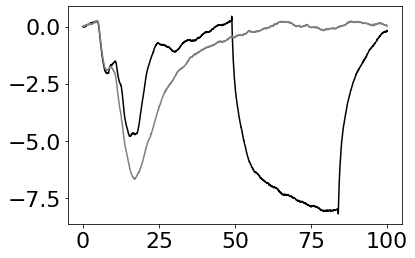

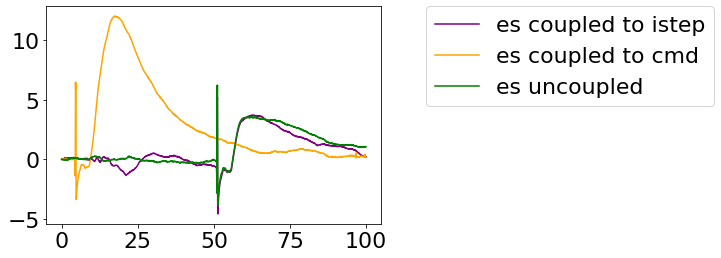

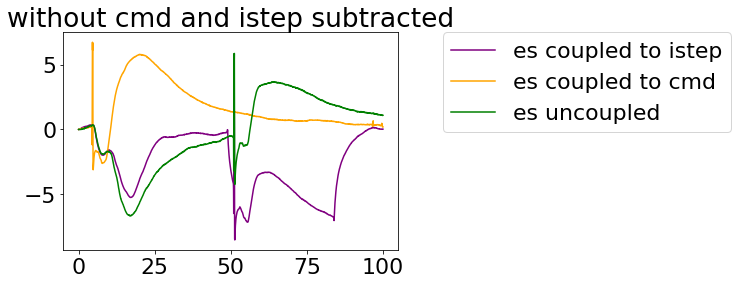

In [51]:
sweepdur = 0.1
plt.figure()

bout = [expt.get_bout_win('B','Keyboard')[3]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
###plot cmd and Istep alone
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0],color = 'black',label='cmd and istep');

bout = [expt.get_bout_win('B','Keyboard')[2],
        expt.get_bout_win('B','Keyboard')[4]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0],color = 'gray',label='cmd ');

plt.figure()

bout = [expt.get_bout_win('B','Keyboard')[3]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
cmdR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

bout = [expt.get_bout_win('U','Keyboard')[4],
       expt.get_bout_win('U','Keyboard')[5]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
###plot ES coupled to istep (with istep subtracted)
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0]-cmdR,color = 'purple',label='es coupled to istep');

bout = [expt.get_bout_win('B','Keyboard')[2],
        expt.get_bout_win('B','Keyboard')[4]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
cmdR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

bout = [expt.get_bout_win('C','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
###plot ES coupled to cmd (with cmd subtracted)
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0]-cmdR,color = 'orange',label='es coupled to cmd');

bout = [expt.get_bout_win('U','Keyboard')[6]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0]-cmdR,color = 'green',label='es uncoupled');

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.figure()

bout = [expt.get_bout_win('U','Keyboard')[4],
       expt.get_bout_win('U','Keyboard')[5]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
###plot ES coupled to istep (with istep subtracted)
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0],color = 'purple',label='es coupled to istep');

bout = [expt.get_bout_win('C','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
###plot ES coupled to cmd (with cmd subtracted)
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0],color = 'orange',label='es coupled to cmd');

bout = [expt.get_bout_win('U','Keyboard')[6]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df['time'].values,sweepdur)
plt.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0],color = 'green',label='es uncoupled');

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('without cmd and istep subtracted')

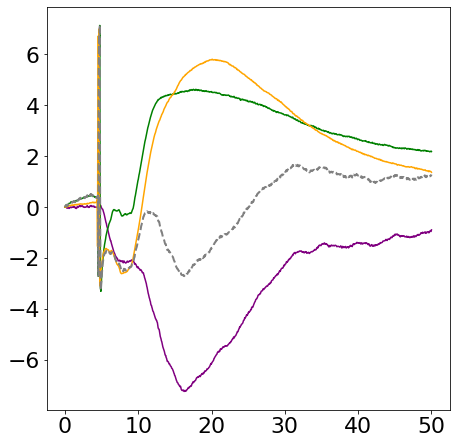

In [55]:
bout = [expt.get_bout_win('U','Keyboard')[6]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
u_df = expt.filter_marker_df_code(bout_df,['U'])
u_t = u_df.time.values-0.0001

bout = [expt.get_bout_win('B','Keyboard')[4]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values

bout = [expt.get_bout_win('C','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
c_df = expt.filter_marker_df_code(bout_df,['C'])
b_df = expt.filter_marker_df_code(bout_df,['B'])
c_t = c_df.time.values
#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

sweepdur = 0.050
basedur = 0.004
nsweeps = 3

fig = plt.figure(figsize = (7,8));ax = fig.add_axes([0.1,0.2,0.8,0.7])

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
cmdR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cmdR,color='purple');

xtime,sweeps = expt.get_sweepsmat('lowgain',u_t-c_latency,sweepdur)
uR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,uR,color='green');

xtime,sweeps = expt.get_sweepsmat('lowgain',c_t-c_latency,sweepdur)
cR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cR,color='orange');

predictedR = cmdR+uR
ax.plot(xtime,predictedR,color='gray',linewidth = 2,linestyle='--');


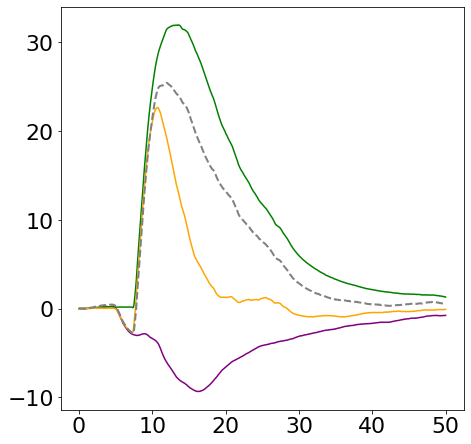

In [54]:
bout = [expt.get_bout_win('e','Keyboard')[2],
        expt.get_bout_win('e','Keyboard')[3]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
u_df = expt.filter_marker_df_code(bout_df,['e'])
u_t = u_df.time.values-0.0001

bout = [expt.get_bout_win('B','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values

bout = [expt.get_bout_win('E','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
c_df = expt.filter_marker_df_code(bout_df,['E'])
b_df = expt.filter_marker_df_code(bout_df,['B'])
c_t = c_df.time.values
#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

sweepdur = 0.050
basedur = 0.004
nsweeps = 3

fig = plt.figure(figsize = (7,8));ax = fig.add_axes([0.1,0.2,0.8,0.7])

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
cmdR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cmdR,color='purple');

xtime,sweeps = expt.get_sweepsmat('lowgain',u_t-c_latency,sweepdur)
uR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,uR,color='green');

xtime,sweeps = expt.get_sweepsmat('lowgain',c_t-c_latency,sweepdur)
cR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cR,color='orange');

predictedR = cmdR+uR
ax.plot(xtime,predictedR,color='gray',linewidth = 2,linestyle='--');


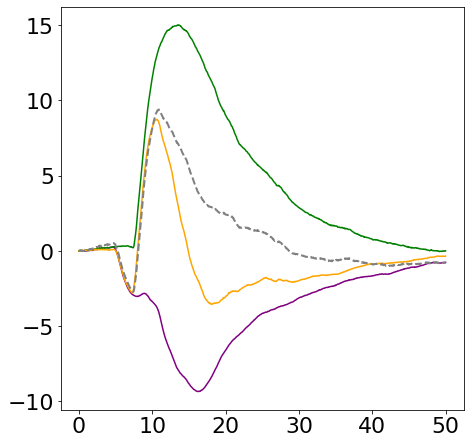

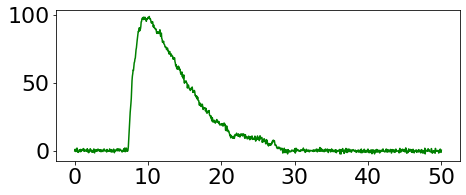

In [58]:
bout = [expt.get_bout_win('e','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
u_df = expt.filter_marker_df_code(bout_df,['e'])
u_t = u_df.time.values-0.0001

bout = [expt.get_bout_win('B','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = b_df.time.values

bout = [expt.get_bout_win('E','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
c_df = expt.filter_marker_df_code(bout_df,['E'])
b_df = expt.filter_marker_df_code(bout_df,['B'])
c_t = c_df.time.values
#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

sweepdur = 0.050
basedur = 0.004
nsweeps = 3

fig = plt.figure(figsize = (7,8));ax = fig.add_axes([0.1,0.2,0.8,0.7])

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
cmdR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cmdR,color='purple');

xtime,sweeps = expt.get_sweepsmat('lowgain',u_t-c_latency,sweepdur)
uR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,uR,color='green');

xtime,sweeps = expt.get_sweepsmat('lowgain',c_t-c_latency,sweepdur)
cR = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
ax.plot(xtime,cR,color='orange');

predictedR = cmdR+uR
ax.plot(xtime,predictedR,color='gray',linewidth = 2,linestyle='--');


fig = plt.figure(figsize = (7,3));ax = fig.add_axes([0.1,0.2,0.8,0.7])

xtime,sweeps = expt.get_sweepsmat('current',u_t-c_latency,sweepdur)
ax.plot(xtime,np.mean(sweeps,1)-np.mean(sweeps,1)[0],color='green');


/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_003.smr


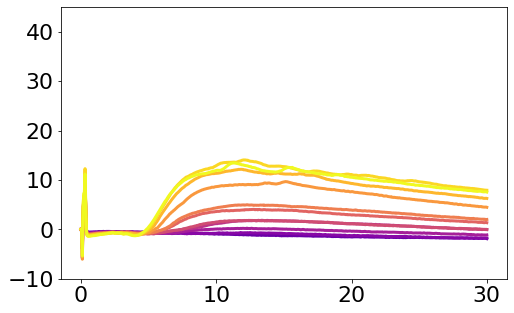

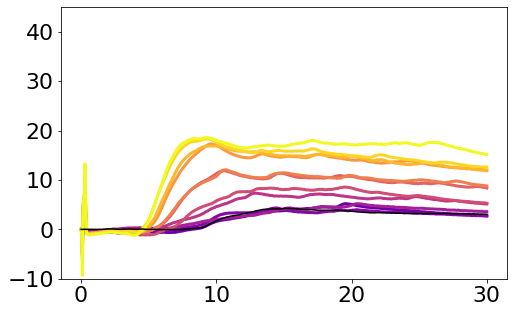

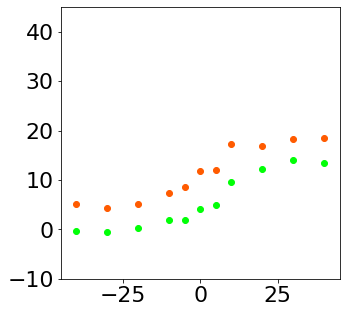

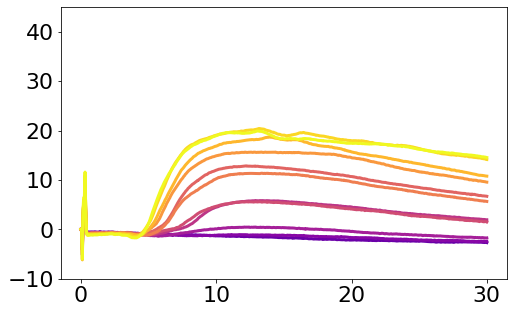

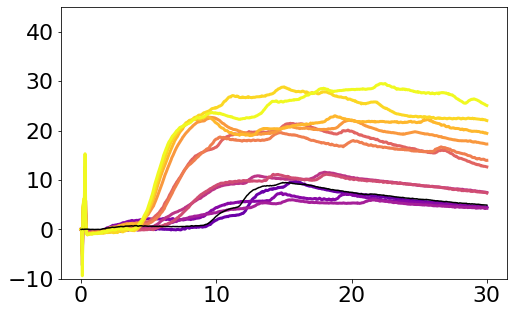

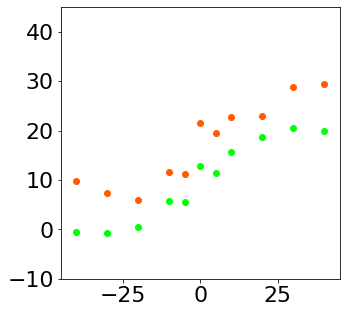

In [80]:
exptname = '20200607_003'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# at rest
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# biased to -65mV
########
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

In [28]:
exptname = '20200607_003'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

# at rest
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

marker_df = expt.get_marker_table()

/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_003.smr


In [ ]:
amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

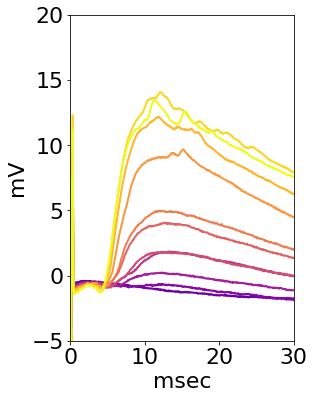

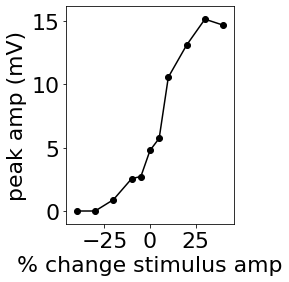

In [34]:
# at rest
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]


sweepdur = 0.03
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

trialmat = []
for a in np.unique(trial_df['ampshift_round']):
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

dt = expt.get_dt('lowgain')

min_peakt = 0.002 #(s)
threshold_h = 0.5 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

sweepdur = 0.03
basedur = 0.004

fsl = []
onset = []
amp = []
for sweep in trialmat.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])
onset = np.asarray(onset)
amp = np.asarray(amp)
fsl = np.asarray(fsl)

plt.figure(figsize=(4,6))
colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
for i,sweep in enumerate(trialmat.T):
    plt.plot(xtime,sweep,color = colinds[i],lw = 2);
plt.xlim(0,30)
plt.ylim(-5,20)
plt.ylabel('mV')
plt.xlabel('msec')


plt.figure(figsize=(3,4))
plt.plot(np.unique(trial_df['ampshift_round']),amp,color = 'black')
plt.scatter(np.unique(trial_df['ampshift_round']),amp,color = 'black')
# plt.ylim(-2,15)
plt.xlabel('% change stimulus amp')
plt.ylabel('peak amp (mV)')

x_data = np.unique(trial_df['ampshift_round'])[~np.isnan(onset)]
y_data = onset[~np.isnan(onset)]



In [8]:
exptname = '20200524_002'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('N','Keyboard')[0]]

In [18]:
sweepdur = 0.05
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout)

base_df = expt.filter_marker_df_code(bout_df,['U'])


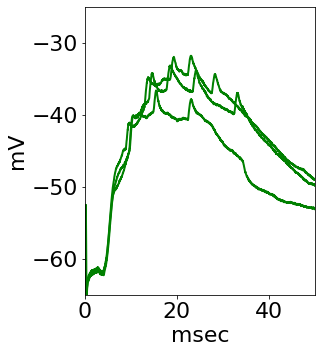

In [21]:
hfig = plt.figure(figsize=(4,5))
ax1 = hfig.add_axes([0.1,0.1,0.8,0.8])
theseT = base_df.time.values
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
ax1.plot(xtime,R[:,-3:],color = 'green',lw = 2,label='baseline stimulus amp')

ax1.set_xlim(0,50)
ax1.set_ylim(-65,-25)
ax1.set_xlabel('msec')
ax1.set_ylabel('mV')

h, l = ax1.get_legend_handles_labels()
# plt.legend(h[0],l[0],bbox_to_anchor=[1,1])

/Users/kperks/mnt/engram/spikedata/data_raw/20200524/20200524_002.smr


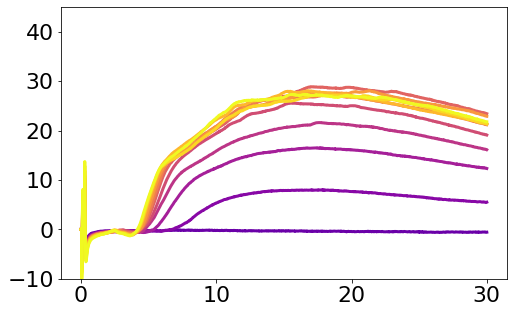

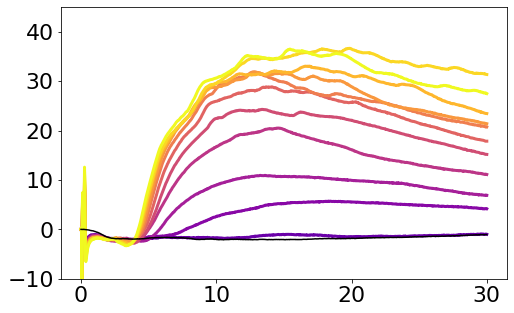

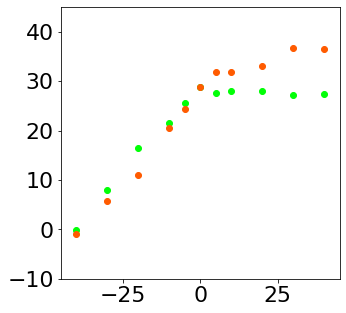

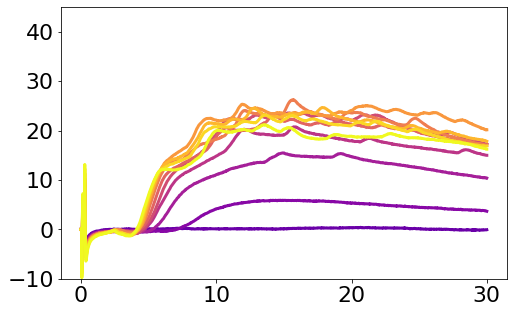

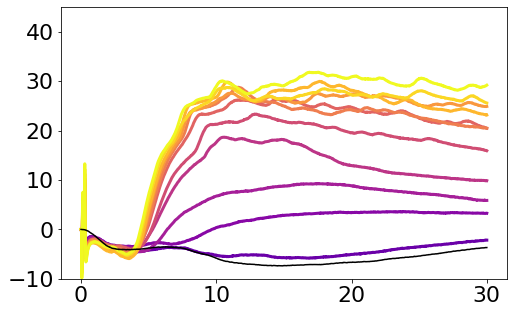

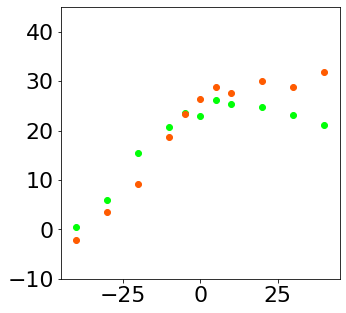

In [81]:
exptname = '20200524_002'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

# biased to -70mV
########
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

#  biased to -60
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

In [35]:
exptname = '20200524_002'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

/Users/kperks/mnt/engram/spikedata/data_raw/20200524/20200524_002.smr


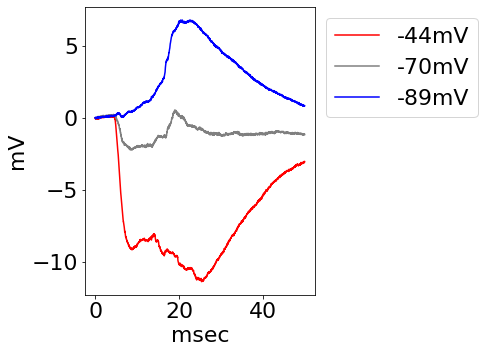

In [43]:
sweepdur = 0.05
marker_df = expt.get_marker_table() 
hfig = plt.figure(figsize=(4,5))
ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.set_ylabel('mV')
ax.set_xlabel('msec')
##cmd
bout = [expt.get_bout_win('B','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
ax.plot(xtime,np.median(sweeps,1)-np.median(sweeps,1)[0],color = 'red',
        label=str(int(np.median(sweeps,1)[0]))+'mV');

bout = [expt.get_bout_win('B','Keyboard')[3]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
ax.plot(xtime,np.median(sweeps,1)-np.median(sweeps,1)[0],color = 'gray',
        label=str(int(np.median(sweeps,1)[0]))+'mV');

bout = [expt.get_bout_win('B','Keyboard')[2]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
ax.plot(xtime,np.median(sweeps,1)-np.median(sweeps,1)[0],color = 'blue',
        label=str(int(np.median(sweeps,1)[0]))+'mV');

plt.legend(bbox_to_anchor=[1,1])

Text(0.5, 1.0, 'at rest')

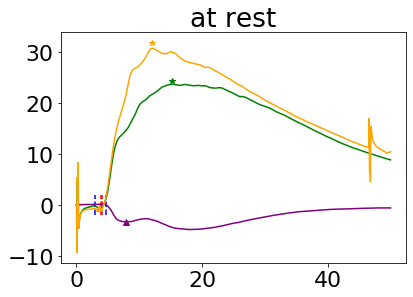

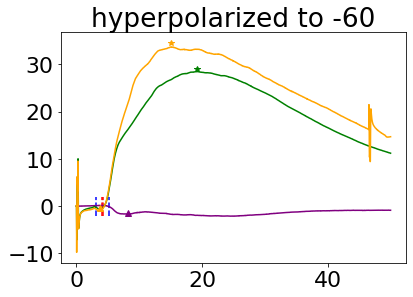

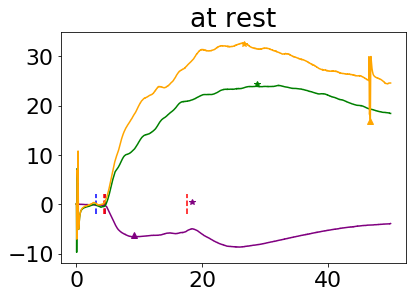

In [26]:
fig = plt.figure(num=1)
ax = fig.add_axes([0.1,0.1,0.8,0.8])

bout = [expt.get_bout_win('N','Keyboard')[0],
       expt.get_bout_win('R','Keyboard')[0]]

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')
bout_df = expt.filter_marker_df_time(marker_df,bout)

b_df = expt.filter_marker_df_code(bout_df,['B'])
u_df = expt.filter_marker_df_code(bout_df,['U'])
c_df = expt.filter_marker_df_code(bout_df,['C'])

u_t = u_df.time.values
c_t = c_df.time.values
#from uncoupled trials get times for command responses
cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in u_t])

#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

cell_data = get_results(expt,cmd_t,u_t,c_t,c_latency,1,ax)
ax.set_title('at rest')

#####hyperpolarized
fig = plt.figure(num=2)
ax = fig.add_axes([0.1,0.1,0.8,0.8])

bout = [expt.get_bout_win('B','Keyboard')[0],
       expt.get_bout_win('U','Keyboard')[1],
       expt.get_bout_win('C','Keyboard')[0]]

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')
bout_df = expt.filter_marker_df_time(marker_df,bout)

b_df = expt.filter_marker_df_code(bout_df,['B'])
u_df = expt.filter_marker_df_code(bout_df,['U'])
c_df = expt.filter_marker_df_code(bout_df,['C'])

u_t = u_df.time.values
c_t = c_df.time.values
#from uncoupled trials get times for command responses
cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in u_t])

#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

cell_data = get_results(expt,cmd_t,u_t,c_t,c_latency,1,ax)
ax.set_title('hyperpolarized to -60')

#############
#at rest at end of expt
fig = plt.figure(num=3)
ax = fig.add_axes([0.1,0.1,0.8,0.8])

bout = [expt.get_bout_win('B','Keyboard')[5],
       expt.get_bout_win('U','Keyboard')[3],
       expt.get_bout_win('C','Keyboard')[2]]

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')
bout_df = expt.filter_marker_df_time(marker_df,bout)

b_df = expt.filter_marker_df_code(bout_df,['B'])
u_df = expt.filter_marker_df_code(bout_df,['U'])
c_df = expt.filter_marker_df_code(bout_df,['C'])

u_t = u_df.time.values
c_t = c_df.time.values
#from uncoupled trials get times for command responses
cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in u_t])

#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

cell_data = get_results(expt,cmd_t,u_t,c_t,c_latency,1,ax)
ax.set_title('at rest')

/Users/kperks/mnt/engram/spikedata/data_raw/20200309/20200309_000.smr


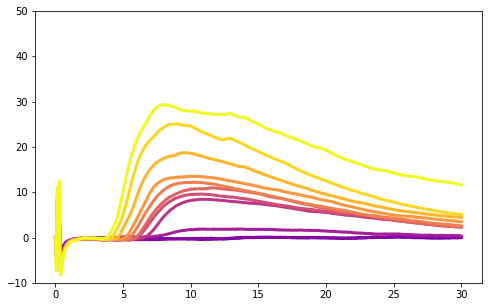

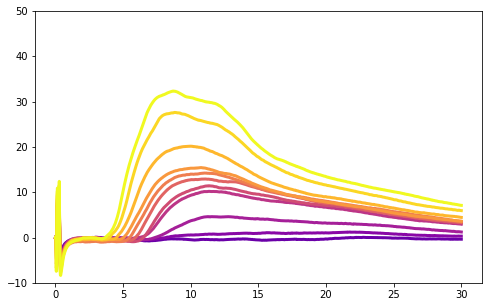

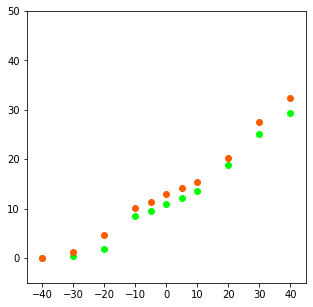

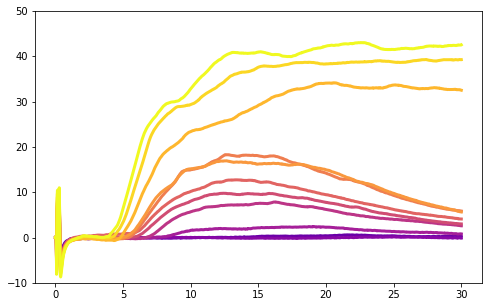

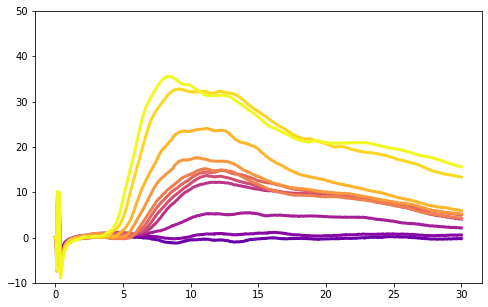

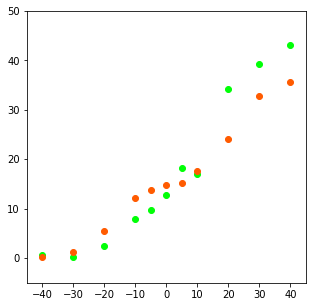

In [6]:
expt = AmpShift_Stable()
expt.load_expt('20200309_000', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

# biased to -65mV
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# not biased
########
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[2]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200122/20200122_002.smr


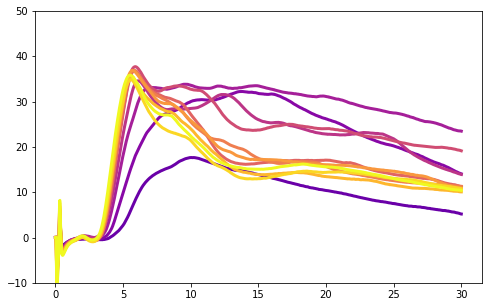

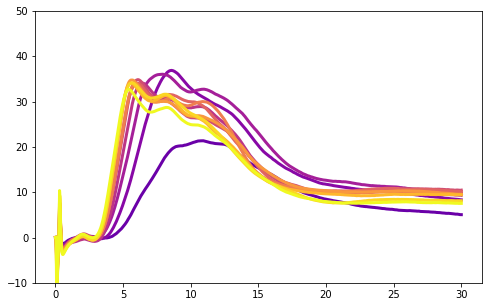

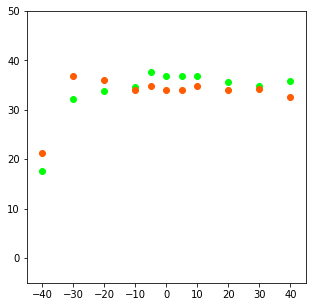

In [7]:
expt = AmpShift_Stable()
expt.load_expt('20200122_002', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

# biased to -65
############
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# took out '20200121_006' because not necessarily an sGRC.... some other cell type? CMD inhibition not there at rest

/Users/kperks/mnt/engram/spikedata/data_raw/20200109/20200109_004.smr


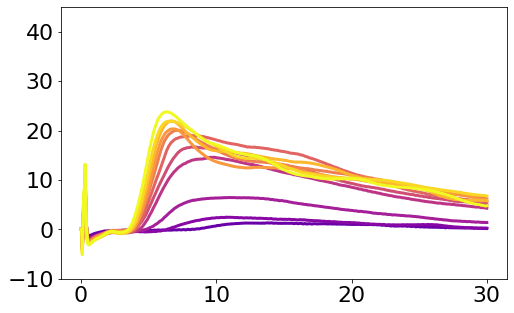

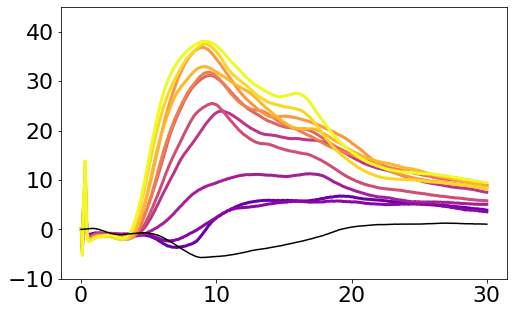

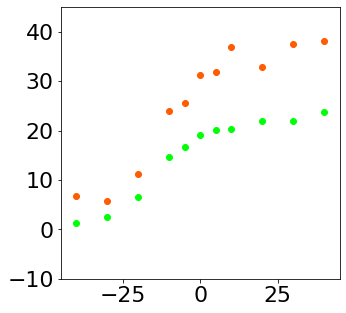

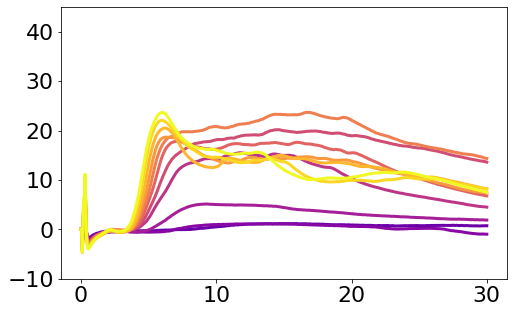

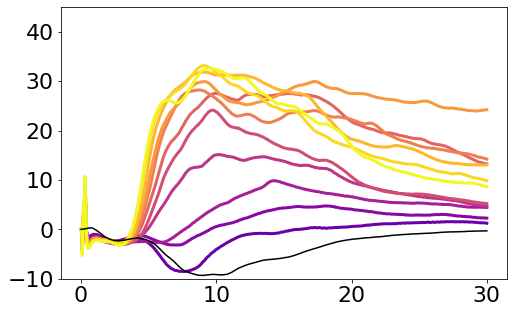

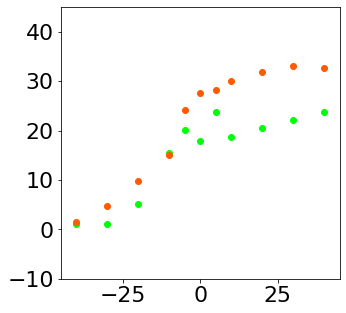

In [79]:
expt = AmpShift_Stable()
expt.load_expt('20200109_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

# hyperpol but drifting
############
bout_uc = [expt.get_bout_win('R','Keyboard')[2]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# not biased
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0],expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20191218/20191218_007.smr


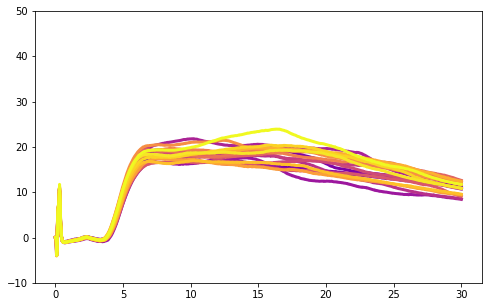

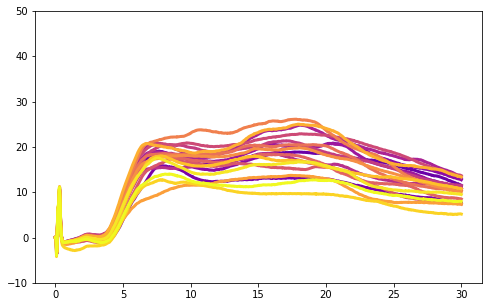

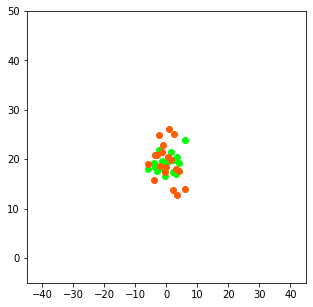

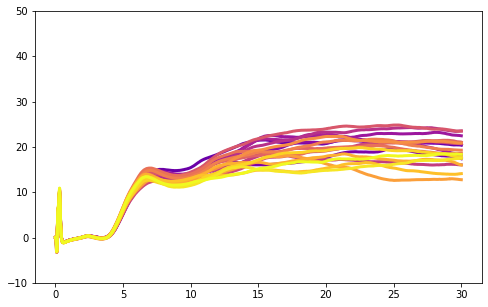

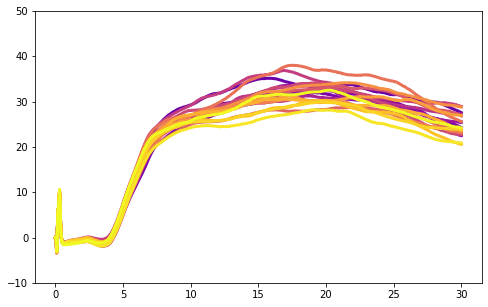

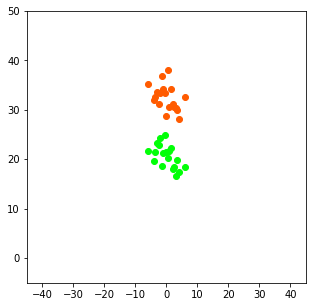

In [10]:
###very small amplitude range
expt = AmpShift_Stable()
expt.load_expt('20191218_007', data_folder)

expt.set_amps(19,[-6,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,6])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

# hyperpol but late in recording and pretty unstable Vm
############
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# not biased
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

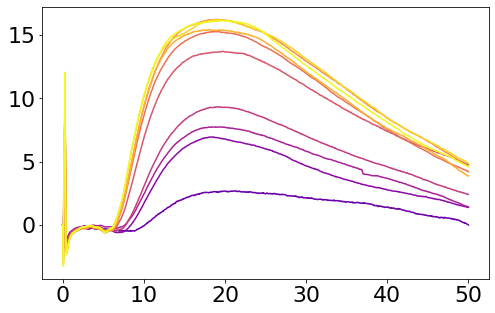

In [64]:
#shifted amplitude manually

# expt = AmpShift_Stable()
# expt.load_expt('20170502_002', data_folder)

expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

########
bout_uc = [expt.get_bout_win('U','Keyboard')[1]]

dt = expt.get_dt('lowgain')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['E'])
u_t = trial_df.time - 0.0003

eventdur = 0.0005
xtime,event_sweeps = expt.get_sweepsmat('lowgain',u_t+0.00015,eventdur)
event_amp = np.asarray([np.max(sweep)-np.min(sweep) for sweep in event_sweeps.T])

sweepdur = 0.05
xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
R_amp = np.asarray([np.max(sweep[int(0.002/dt):]- sweep[0]) for sweep in sweeps.T])

bins = np.arange(np.floor(np.min(event_amp)),np.ceil(np.max(event_amp))+1)
ind = np.digitize(event_amp,bins)

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,len(np.unique(ind))))
for i in np.unique(ind):
    Ravg = np.mean(sweeps[:,(ind==i)],1)
    plt.plot(xtime,Ravg-Ravg[0],color = colinds[i-1])

/Users/kperks/mnt/engram/spikedata/data_raw/20170607/20170607_005.smr


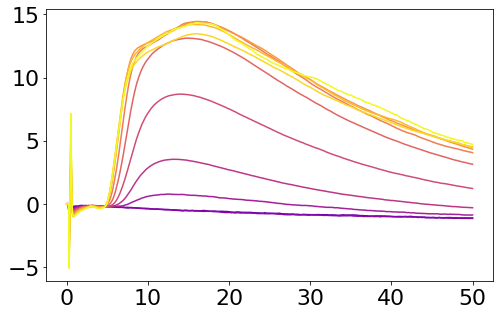

In [65]:
#shifted amplitude manually
exptname = '20170607_005'

expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

########
bout_uc = [expt.get_bout_win('U','Keyboard')[0]]

dt = expt.get_dt('lowgain')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['E'])
u_t = trial_df.time - 0.0003

eventdur = 0.0005
xtime,event_sweeps = expt.get_sweepsmat('lowgain',u_t+0.00015,eventdur)
event_amp = np.asarray([np.max(sweep)-np.min(sweep) for sweep in event_sweeps.T])

sweepdur = 0.05
xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
R_amp = np.asarray([np.max(sweep[int(0.002/dt):]- sweep[0]) for sweep in sweeps.T])

bins = np.arange(np.floor(np.min(event_amp)),np.ceil(np.max(event_amp))+1)
ind = np.digitize(event_amp,bins)

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,len(np.unique(ind))))
for i in np.unique(ind):
    Ravg = np.mean(sweeps[:,(ind==i)],1)
    plt.plot(xtime,Ravg-Ravg[0],color = colinds[i-1])

In [67]:
event_amp_uc = event_amp
R_amp_uc = R_amp
# plt.scatter(event_amp,R_amp)

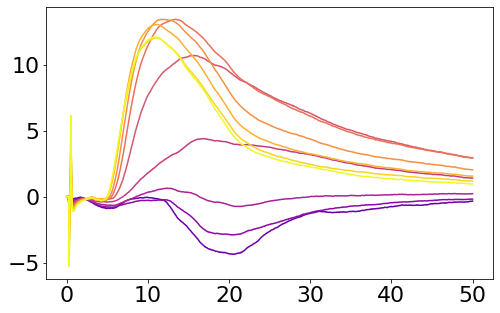

In [83]:

dt = expt.get_dt('lowgain')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_c = [expt.get_bout_win('C','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['E'])
c_t = trial_df.time - 0.0003
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

bout_cmd = [expt.get_bout_win('B','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout_cmd)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = trial_df.time

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t+c_latency,sweepdur)
cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

eventdur = 0.0005
xtime,event_sweeps = expt.get_sweepsmat('lowgain',c_t+0.00015,eventdur)
event_amp = np.asarray([np.max(sweep)-np.min(sweep) for sweep in event_sweeps.T])

sweepdur = 0.05
xtime,sweeps = expt.get_sweepsmat('lowgain',c_t,sweepdur)
sweeps = np.asarray([sweep-cmd_ for sweep in sweeps.T]).T
R_amp = np.asarray([np.max(sweep[int(0.002/dt):]- sweep[0]) for sweep in sweeps.T])

#use bins and ind from uncoupled so can compare
# bins = np.arange(np.floor(np.min(event_amp)),np.ceil(np.max(event_amp))+1)
ind = np.digitize(event_amp,bins)

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,len(np.unique(ind))))
for i in np.unique(ind):
    Ravg = np.mean(sweeps[:,(ind==i)],1)
    plt.plot(xtime,Ravg-Ravg[0],color = colinds[i-1])
    
event_amp_c = event_amp
R_amp_c = R_amp

Text(0.5, 1.0, 'cmd subtracted from coupled (orange)')

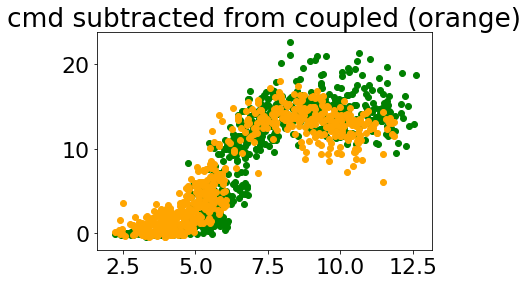

In [80]:
plt.figure()
plt.scatter(event_amp_uc,R_amp_uc,color = 'green')
plt.scatter(event_amp_c,R_amp_c,color = 'orange')
plt.title('cmd subtracted from coupled (orange)')

Text(0.5, 1.0, 'cmd not subtracted')

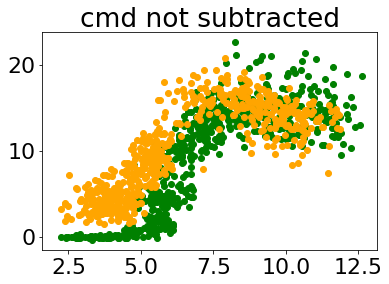

In [82]:
plt.figure()
plt.scatter(event_amp_uc,R_amp_uc,color = 'green')
plt.scatter(event_amp_c,R_amp_c,color = 'orange')
plt.title('cmd not subtracted')